importing the modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  TimeSeriesSplit




In [ ]:
!pip install alpha_vantage

In [ ]:
from alpha_vantage.foreignexchange import ForeignExchange

In [ ]:
!pip install yfinance
import yfinance as yf

data exploration and cleaning

In [ ]:
data = yf.download('EURUSD=X', start='2010-01-01', end='2024-11-08', interval='1d')
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X   
Date                                                                          
2010-01-01 00:00:00+00:00  1.438994  1.438994  1.440196  1.432706  1.432706   
2010-01-04 00:00:00+00:00  1.442398  1.442398  1.445191  1.426208  1.431004   
2010-01-05 00:00:00+00:00  1.436596  1.436596  1.448310  1.435194  1.442710   
2010-01-06 00:00:00+00:00  1.440403  1.440403  1.443460  1.429123  1.436596   
2010-01-07 00:00:00+00:00  1.431803  1.431803  1.444481  1.430206  1.440300   

Price                       Volume  
Ticker                    EURUSD=X  
Date                                
2010-01-01 00:00:00+00:00        0  
2010-01-04 00:00:00+00:00        0  
2010-01-05 00:00:00+00:00        0  
2010-01-06 00:00:00+00:00        0  
2010-01-07 00:00:00+00:00        0  


In [ ]:
data.shape

(3870, 6)

In [ ]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3870 entries, 2010-01-01 00:00:00+00:00 to 2024-11-07 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, EURUSD=X)  3870 non-null   float64
 1   (Close, EURUSD=X)      3870 non-null   float64
 2   (High, EURUSD=X)       3870 non-null   float64
 3   (Low, EURUSD=X)        3870 non-null   float64
 4   (Open, EURUSD=X)       3870 non-null   float64
 5   (Volume, EURUSD=X)     3870 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 211.6 KB
None


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib  # For loading the model

# Class to handle real-time data retrieval and signal generation
class SimpleSignalGenerator:
    def __init__(self, ticker, model_filename='svc_model.pkl', window_size=20, threshold=0.02):
        self.ticker = ticker
        self.model_filename = model_filename
        self.window_size = window_size
        self.threshold = threshold
        self.model = self.load_model()

    def load_model(self):
        # Load the trained model
        model = joblib.load(self.model_filename)
        return model

    def get_real_time_data(self):
        # Retrieve real-time stock data (last 1000 data points for example)
        data = yf.download(self.ticker, period='1d', interval='1m')  # 1-minute interval data for real-time
        return data

    def preprocess_data(self, data):
        # Calculate the moving average for mean reversion strategy
        data['MovingAverage'] = data['Close'].rolling(window=self.window_size).mean()

        # Calculate the Mean Reversion Signal
        data['MeanReversionSignal'] = np.where(data['Close'] > data['MovingAverage'] * (1 + self.threshold), -1,
                                               np.where(data['Close'] < data['MovingAverage'] * (1 - self.threshold), 1, 0))

        # Remove rows with NaN values (if any)
        data = data.dropna()

        return data

    def generate_trading_signals(self, data):
        # Preprocess the data
        data = self.preprocess_data(data)

        # Generate trading signals based on model predictions
        data['Signal'] = self.model.predict(data[['Adj Close', 'High', 'Low', 'Open', 'Volume', 'MovingAverage', 'MeanReversionSignal']])
        data['Trade'] = np.where(data['Signal'] == 1, 'Buy', np.where(data['Signal'] == -1, 'Sell', 'Hold'))

        # Return the latest trading signal
        return data[['Close', 'Trade']].tail(1)  # Only the most recent data point

    def get_and_generate_signals(self):
        # Retrieve the latest real-time data
        real_time_data = self.get_real_time_data()

        # Generate trading signals for the latest data
        signals = self.generate_trading_signals(real_time_data)
        return signals


# Example usage:
if __name__ == "__main__":
    # Initialize the signal generator with the stock ticker
    signal_generator = SimpleSignalGenerator(ticker='AAPL')  # Example: Apple stock

    # Generate trading signals
    trading_signal = signal_generator.get_and_generate_signals()

    # Print the latest trading signal
    print(trading_signal)


FileNotFoundError: [Errno 2] No such file or directory: 'svc_model.pkl'

In [ ]:
print(data.isnull().sum())


Price      Ticker  
Adj Close  EURUSD=X    0
Close      EURUSD=X    0
High       EURUSD=X    0
Low        EURUSD=X    0
Open       EURUSD=X    0
Volume     EURUSD=X    0
dtype: int64


In [ ]:
duplicates = data[data.duplicated()]
print("Number of duplicate rows:", duplicates.shape[0])

Number of duplicate rows: 0


In [ ]:

data_cleaned = data[~data.index.duplicated(keep='first')]

duplicates = data[data.index.duplicated()]
print("Number of duplicate rows:", duplicates.shape[0])

Number of duplicate rows: 0


In [ ]:

def detect_outliers(data):
    outliers = {}
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        # Drop NaN values for this calculation
        col_data = data[column].dropna()

        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers[column] = col_data[(col_data < lower_bound) | (col_data > upper_bound)]

    return outliers

outliers_found = detect_outliers(data)

# Display the results
for column, outliers in outliers_found.items():
    print(f"Outliers in {column}:")
    print(outliers)
    print("\n")


Outliers in ('Adj Close', 'EURUSD=X'):
Series([], Name: (Adj Close, EURUSD=X), dtype: float64)


Outliers in ('Close', 'EURUSD=X'):
Series([], Name: (Close, EURUSD=X), dtype: float64)


Outliers in ('High', 'EURUSD=X'):
Series([], Name: (High, EURUSD=X), dtype: float64)


Outliers in ('Low', 'EURUSD=X'):
Date
2012-01-27 00:00:00+00:00    0.760572
Name: (Low, EURUSD=X), dtype: float64


Outliers in ('Open', 'EURUSD=X'):
Series([], Name: (Open, EURUSD=X), dtype: float64)


Outliers in ('Volume', 'EURUSD=X'):
Series([], Name: (Volume, EURUSD=X), dtype: int64)




In [ ]:

outlier_date = '2012-01-27'
data_cleaned = data[data.index != outlier_date]

print("Data after removing the outlier:")
print(data_cleaned)


Data after removing the outlier:
Price                     Adj Close     Close      High       Low      Open  \
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X   
Date                                                                          
2010-01-01 00:00:00+00:00  1.438994  1.438994  1.440196  1.432706  1.432706   
2010-01-04 00:00:00+00:00  1.442398  1.442398  1.445191  1.426208  1.431004   
2010-01-05 00:00:00+00:00  1.436596  1.436596  1.448310  1.435194  1.442710   
2010-01-06 00:00:00+00:00  1.440403  1.440403  1.443460  1.429123  1.436596   
2010-01-07 00:00:00+00:00  1.431803  1.431803  1.444481  1.430206  1.440300   
...                             ...       ...       ...       ...       ...   
2024-11-01 00:00:00+00:00  1.088613  1.088613  1.090405  1.084846  1.088613   
2024-11-04 00:00:00+00:00  1.087453  1.087453  1.091584  1.087039  1.087453   
2024-11-05 00:00:00+00:00  1.087406  1.087406  1.092180  1.087335  1.087406   
2024-11-06 00:00:00

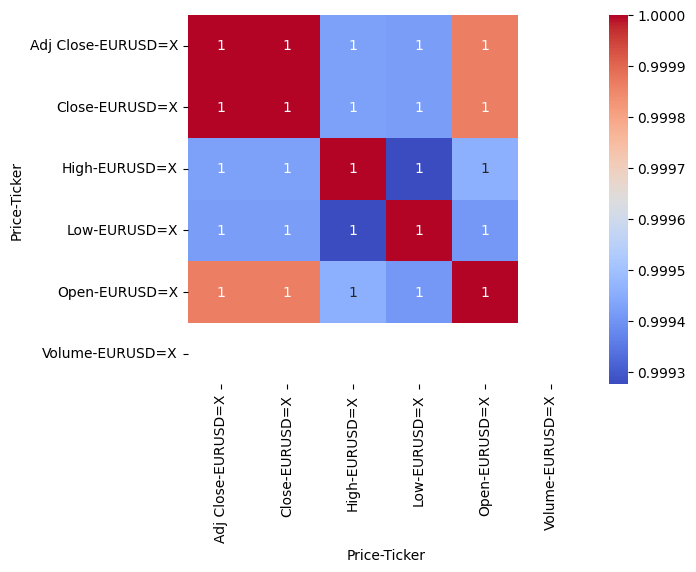

In [ ]:


corr_matrix = data_cleaned[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
print(data_cleaned.describe())

Price     Adj Close        Close         High          Low         Open  \
Ticker     EURUSD=X     EURUSD=X     EURUSD=X     EURUSD=X     EURUSD=X   
count   3869.000000  3869.000000  3869.000000  3869.000000  3869.000000   
mean       1.191483     1.191483     1.195556     1.187350     1.191505   
std        0.113775     0.113775     0.114395     0.113170     0.113834   
min        0.959619     0.959619     0.967006     0.954016     0.959619   
25%        1.099384     1.099384     1.103000     1.095554     1.099372   
50%        1.158856     1.158856     1.161980     1.154935     1.158869   
75%        1.295337     1.295337     1.299596     1.291005     1.295203   
max        1.484406     1.484406     1.493808     1.480494     1.484296   

Price    Volume  
Ticker EURUSD=X  
count    3869.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  


In [ ]:
data.columns


MultiIndex([('Adj Close', 'EURUSD=X'),
            (    'Close', 'EURUSD=X'),
            (     'High', 'EURUSD=X'),
            (      'Low', 'EURUSD=X'),
            (     'Open', 'EURUSD=X'),
            (   'Volume', 'EURUSD=X')],
           names=['Price', 'Ticker'])

In [ ]:
data.columns = [' '.join(col).strip() for col in data.columns.values]
data.columns

Index(['Adj Close EURUSD=X', 'Close EURUSD=X', 'High EURUSD=X', 'Low EURUSD=X',
       'Open EURUSD=X', 'Volume EURUSD=X'],
      dtype='object')

In [ ]:
# Fix column names to remove extra spaces
data.columns = [' '.join(col).replace(" ", "") for col in data.columns.values]

# Check the cleaned column names
print(data.columns)


Index(['AdjCloseEURUSD=X', 'CloseEURUSD=X', 'HighEURUSD=X', 'LowEURUSD=X',
       'OpenEURUSD=X', 'VolumeEURUSD=X'],
      dtype='object')


In [ ]:
# Clean column names by removing 'EURUSD=X'
data.columns = data.columns.str.replace(r'EURUSD=X', '', regex=True)
data.columns = data.columns.str.strip()  # Remove any extra spaces

print(data.columns)


Index(['AdjClose', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


feature engineering

In [ ]:
# Calculate 50-day and 200-day SMA and EMA
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# Check results
print("SMA50:", data['SMA50'].head(60))  # Display first 60 rowsa

# Check for empty or NaN values in SMA
print("SMA50 NaN counts:", data['SMA50'].isna().sum())

# Calculate EMA (50 and 200-day)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Check results for EMA
print("EMA50:", data['EMA50'].head(60))  # Display first 60 rows

# Check for empty or NaN values in EMA
print("EMA50 NaN counts:", data['EMA50'].isna().sum())


SMA50: Date
2010-01-01 00:00:00+00:00         NaN
2010-01-04 00:00:00+00:00         NaN
2010-01-05 00:00:00+00:00         NaN
2010-01-06 00:00:00+00:00         NaN
2010-01-07 00:00:00+00:00         NaN
2010-01-08 00:00:00+00:00         NaN
2010-01-11 00:00:00+00:00         NaN
2010-01-12 00:00:00+00:00         NaN
2010-01-13 00:00:00+00:00         NaN
2010-01-14 00:00:00+00:00         NaN
2010-01-15 00:00:00+00:00         NaN
2010-01-18 00:00:00+00:00         NaN
2010-01-19 00:00:00+00:00         NaN
2010-01-20 00:00:00+00:00         NaN
2010-01-21 00:00:00+00:00         NaN
2010-01-22 00:00:00+00:00         NaN
2010-01-25 00:00:00+00:00         NaN
2010-01-26 00:00:00+00:00         NaN
2010-01-27 00:00:00+00:00         NaN
2010-01-28 00:00:00+00:00         NaN
2010-01-29 00:00:00+00:00         NaN
2010-02-01 00:00:00+00:00         NaN
2010-02-02 00:00:00+00:00         NaN
2010-02-03 00:00:00+00:00         NaN
2010-02-04 00:00:00+00:00         NaN
2010-02-05 00:00:00+00:00         NaN


In [ ]:
data.dropna(subset=['SMA50'], inplace=True)


feature scaling and model training




In [ ]:


data.loc[:, 'SMA_5'] = data['Close'].rolling(window=5).mean()
data.loc[:, 'SMA_10'] = data['Close'].rolling(window=10).mean()
data.loc[:, 'SMA_20'] = data['Close'].rolling(window=20).mean()

data.loc[:, 'EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
data.loc[:, 'EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

data.loc[:, 'ROC_5'] = data['Close'].pct_change(periods=5)
data.loc[:, 'Price_Change'] = data['Close'].pct_change()
data.loc[:, 'Lag_1'] = data['Close'].shift(1)
data.loc[:, 'Volatility_5'] = data['Close'].rolling(window=5).std()
data.loc[:, 'Cumulative_Returns'] = (1 + data['Price_Change']).cumprod() - 1
data.loc[:, 'Volume_SMA_7'] = data['Volume'].rolling(window=7).mean()

data = data.dropna()

X = data[['SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'ROC_5', 'Price_Change', 'Lag_1', 'Volatility_5', 'Cumulative_Returns', 'Volume_SMA_7']]
y = data['Close']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



model training

In [ ]:
# Prepare feature set and target variable
X = data[['SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'ROC_5', 'Price_Change',
          'Lag_1', 'Volatility_5', 'Cumulative_Returns', 'Volume_SMA_7']]
y = data['Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
svm_model = SVR()

# Define hyperparameters to search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernels to try
    'C': [0.1, 1, 10, 100],               # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1] # Gamma values
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters: ", grid_search.best_params_)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Now that the model is fitted, predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred)
# Use best_model instead of svm_model for calculating the score
r2 = best_model.score(X_test, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Squared Error: 0.0011696137585869876
R^2 Score: 0.909596645606535


checking for fitting

In [ ]:

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Predicting on training data
y_train_pred = best_model.predict(X_train)  # Changed from svm_model to best_model
train_mse = mean_squared_error(y_train, y_train_pred)

# Predicting on testing data
y_test_pred = best_model.predict(X_test)  # Changed from svm_model to best_model
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.00112697683409878
Test MSE: 0.0011696137585869876


signal generation

In [ ]:
svm_model.fit(X_train, y_train)

X_scaled_full = scaler.transform(data[['SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'ROC_5', 'Price_Change',
                                      'Lag_1', 'Volatility_5', 'Cumulative_Returns', 'Volume_SMA_7']])
data['SVM_Prediction'] = svm_model.predict(X_scaled_full)

# Default signal
data['Signal'] = 0

# Generate Buy signal: SMA_5 > SMA_20 and SVM Prediction indicates an upward trend
data.loc[(data['SMA_5'] > data['SMA_20']) & (data['SVM_Prediction'] > data['SVM_Prediction'].shift(1)), 'Signal'] = 1

# Generate Sell signal: SMA_5 < SMA_20 and SVM Prediction indicates a downward trend
data.loc[(data['SMA_5'] < data['SMA_20']) & (data['SVM_Prediction'] < data['SVM_Prediction'].shift(1)), 'Signal'] = -1

# Add signal changes (Position)
data['Position'] = data['Signal'].diff()

# Print generated signals
print(data[['Close', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'ROC_5', 'Price_Change',
            'Lag_1', 'Volatility_5', 'Cumulative_Returns', 'Volume_SMA_7', 'Signal', 'Position', 'SVM_Prediction']].tail())


                              Close     SMA_5    SMA_10    SMA_20     EMA_5  \
Date                                                                          
2024-11-01 00:00:00+00:00  1.088613  1.083586  1.082677  1.087408  1.084895   
2024-11-04 00:00:00+00:00  1.087453  1.085145  1.082736  1.086908  1.085748   
2024-11-05 00:00:00+00:00  1.087406  1.086291  1.083298  1.086399  1.086300   
2024-11-06 00:00:00+00:00  1.093446  1.088567  1.084670  1.086193  1.088682   
2024-11-07 00:00:00+00:00  1.073307  1.086045  1.084196  1.085142  1.083557   

                             EMA_10     ROC_5  Price_Change     Lag_1  \
Date                                                                    
2024-11-01 00:00:00+00:00  1.084795  0.005726      0.002482  1.085918   
2024-11-04 00:00:00+00:00  1.085278  0.007221     -0.001066  1.088613   
2024-11-05 00:00:00+00:00  1.085665  0.005296     -0.000044  1.087453   
2024-11-06 00:00:00+00:00  1.087080  0.010519      0.005555  1.087406   
2024-11-

In [ ]:
feature_names = scaler.get_feature_names_out()
print(feature_names)

['SMA_5' 'SMA_10' 'SMA_20' 'EMA_5' 'EMA_10' 'ROC_5' 'Price_Change' 'Lag_1'
 'Volatility_5' 'Cumulative_Returns' 'Volume_SMA_7']


In [ ]:
data['Predicted_Close'] = svm_model.predict(scaler.transform(X))
data['Predicted_Signal'] = 0
data.loc[data['Predicted_Close'] > data['Close'].shift(1), 'Predicted_Signal'] = 1
data.loc[data['Predicted_Close'] < data['Close'].shift(1), 'Predicted_Signal'] = -1
data['Predicted_Position'] = data['Predicted_Signal'].diff()


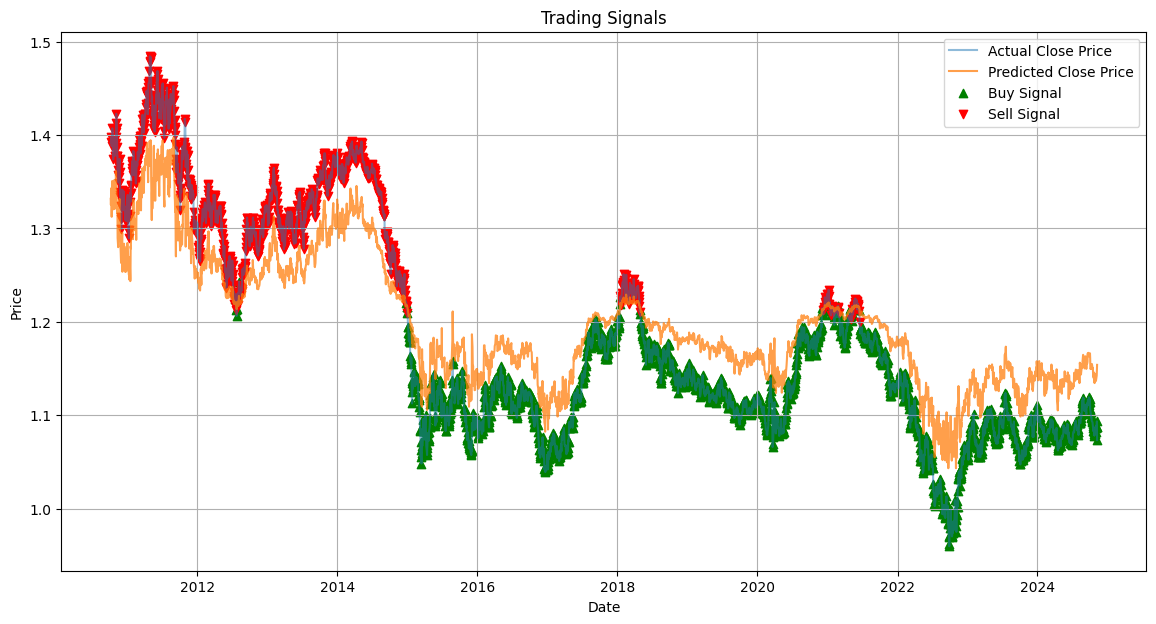

In [ ]:

# Visualize Buy/Sell Signals
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Actual Close Price', alpha=0.5)
plt.plot(data['Predicted_Close'], label='Predicted Close Price', alpha=0.75)
plt.scatter(data.index[data['Predicted_Signal'] == 1], data['Close'][data['Predicted_Signal'] == 1],
            label='Buy Signal', marker='^', color='green')
plt.scatter(data.index[data['Predicted_Signal'] == -1], data['Close'][data['Predicted_Signal'] == -1],
            label='Sell Signal', marker='v', color='red')
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


postion sizing

In [ ]:
available_capital = 100000
risk_per_trade = 0.10  # 10% of capital per trade
capital_per_trade = available_capital * risk_per_trade

# Set stop-loss and take-profit thresholds (as percentage of the asset's price)
stop_loss_percentage = 0.02  # 2% stop-loss
take_profit_percentage = 0.05  # 5% take-profit

# Initialize position size to 0.02
data['Position_Size'] = 0.02

# Position size for Buy signals
data.loc[data['Signal'] == 1, 'Position_Size'] = capital_per_trade / data['Close']

# For Sell signals, position size is negative (opposite of Buy)
data.loc[data['Signal'] == -1, 'Position_Size'] = -capital_per_trade / data['Close']

# Integrate SVM predictions: Use a threshold to only take significant trades based on SVM predictions
threshold = 0.01  # Only take trades when SVM predicts a significant change (1%)

# Adjust position size for Buy signals if SVM prediction is positive and above threshold
data.loc[(data['Signal'] == 1) &
          (data['SVM_Prediction'] > data['SVM_Prediction'].shift(1)) &
          (data['SVM_Prediction'].pct_change() > threshold), 'Position_Size'] = capital_per_trade / data['Close']

# Adjust position size for Sell signals if SVM prediction is negative and below threshold
data.loc[(data['Signal'] == -1) &
          (data['SVM_Prediction'] < data['SVM_Prediction'].shift(1)) &
          (data['SVM_Prediction'].pct_change() < -threshold), 'Position_Size'] = -capital_per_trade / data['Close']

# Implement risk management: Set stop-loss and take-profit levels based on price change
data['Stop_Loss'] = data['Close'] * (1 - stop_loss_percentage)
data['Take_Profit'] = data['Close'] * (1 + take_profit_percentage)

# Simulate trade exits based on stop-loss or take-profit conditions
data['Exit'] = 0  # Default no exit
data.loc[data['Close'] <= data['Stop_Loss'], 'Exit'] = -1  # Exit if price hits stop-loss (sell)
data.loc[data['Close'] >= data['Take_Profit'], 'Exit'] = 1  # Exit if price hits take-profit (sell)

print(data[['Close', 'Signal', 'Position_Size', 'SVM_Prediction', 'Stop_Loss', 'Take_Profit', 'Exit']].tail())


                              Close  Signal  Position_Size  SVM_Prediction  \
Date                                                                         
2024-11-01 00:00:00+00:00  1.088613      -1   -9186.000621        1.136646   
2024-11-04 00:00:00+00:00  1.087453       0       0.020000        1.140874   
2024-11-05 00:00:00+00:00  1.087406       0       0.020000        1.142441   
2024-11-06 00:00:00+00:00  1.093446       1    9145.399902        1.147069   
2024-11-07 00:00:00+00:00  1.073307       1    9316.999482        1.153847   

                           Stop_Loss  Take_Profit  Exit  
Date                                                     
2024-11-01 00:00:00+00:00   1.066841     1.143044     0  
2024-11-04 00:00:00+00:00   1.065704     1.141826     0  
2024-11-05 00:00:00+00:00   1.065658     1.141776     0  
2024-11-06 00:00:00+00:00   1.071577     1.148118     0  
2024-11-07 00:00:00+00:00   1.051841     1.126972     0  


portfolio optimization

drawdown

<ipython-input-29-36ab2c5a2399>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10035.643053528858' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1] * (1 + data['Returns'].iloc[i])


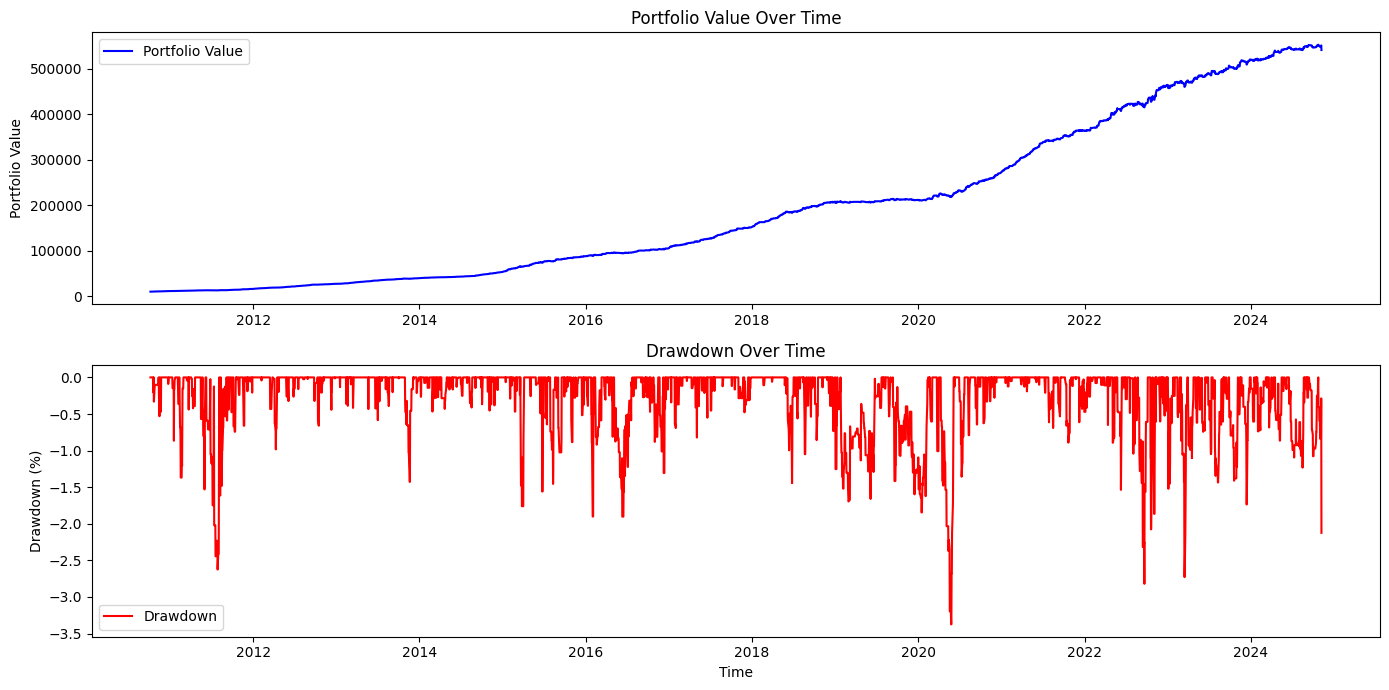

Maximum Drawdown: -3.37%
The maximum drawdown of -3.37% is within the acceptable range.


In [ ]:

# Initial capital
initial_capital = 10000  # Starting portfolio value

# Calculate Returns from Close price
data['Returns'] = data['Close'].pct_change()

# Initialize Portfolio Value column with initial capital
data['Portfolio_Value'] = initial_capital

# Loop through the signals and update portfolio value
for i in range(1, len(data)):
    if data['Signal'].iloc[i] == 1:  # Buy signal
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1] * (1 + data['Returns'].iloc[i])
    elif data['Signal'].iloc[i] == -1:  # Sell signal
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1] * (1 - data['Returns'].iloc[i])
    else:  # Hold position
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1]

# Calculate Drawdown
data['Peak'] = data['Portfolio_Value'].cummax()  # Track running maximum portfolio value
data['Drawdown'] = (data['Portfolio_Value'] - data['Peak']) / data['Peak'] * 100  # Calculate drawdown as a percentage

# Plot portfolio performance and drawdown
plt.figure(figsize=(14, 7))

# Plot portfolio value over time
plt.subplot(2, 1, 1)
plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Plot drawdown over time
plt.subplot(2, 1, 2)
plt.plot(data['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.ylabel('Drawdown (%)')
plt.xlabel('Time')
plt.legend()

# Layout adjustment and display
plt.tight_layout()
plt.show()

# Maximum drawdown
max_drawdown = data['Drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Define acceptable drawdown threshold (you can adjust this value)
acceptable_drawdown_threshold = -6.0  # -6 is the maximum drawdown, i mean we are not settling for less

# Evaluate whether the drawdown is acceptable
if max_drawdown < acceptable_drawdown_threshold:
    print(f"The maximum drawdown of {max_drawdown:.2f}% exceeds the acceptable threshold of {acceptable_drawdown_threshold}%")
    print("Consider re-evaluating the portfolio strategy.")
else:
    print(f"The maximum drawdown of {max_drawdown:.2f}% is within the acceptable range.")


In [ ]:

initial_capital = 100000  # Starting portfolio value

# Calculate Returns from Close price
data['Returns'] = data['Close'].pct_change()

# Initialize Portfolio Value column with initial capital
data['Portfolio_Value'] = initial_capital

# Loop through the signals and update portfolio value
for i in range(1, len(data)):
    if data['Signal'].iloc[i] == 1:  # Buy signal
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1] * (1 + data['Returns'].iloc[i])
    elif data['Signal'].iloc[i] == -1:  # Sell signal
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1] * (1 - data['Returns'].iloc[i])
    else:  # Hold position
        data.loc[data.index[i], 'Portfolio_Value'] = data['Portfolio_Value'].iloc[i - 1]

# Calculate Drawdown
data['Peak'] = data['Portfolio_Value'].cummax()  # Track running maximum portfolio value
data['Drawdown'] = (data['Portfolio_Value'] - data['Peak']) / data['Peak'] * 100  # Calculate drawdown as a percentage

# Plot portfolio performance and drawdown
plt.figure(figsize=(14, 7))

# Plot portfolio value over time
plt.subplot(2, 1, 1)
plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Plot drawdown over time
plt.subplot(2, 1, 2)
plt.plot(data['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.ylabel('Drawdown (%)')
plt.xlabel('Time')
plt.legend()

# Layout adjustment and display
plt.tight_layout()
plt.show()

# Maximum drawdown
max_drawdown = data['Drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Define acceptable drawdown threshold (you can adjust this value)
acceptable_drawdown_threshold = -6.0

# Evaluate whether the drawdown is acceptable
if max_drawdown < acceptable_drawdown_threshold:
    print(f"The maximum drawdown of {max_drawdown:.2f}% exceeds the acceptable threshold of {acceptable_drawdown_threshold}%")
    print("Consider re-evaluating the portfolio strategy.")
else:
    print(f"The maximum drawdown of {max_drawdown:.2f}% is within the acceptable range.")


NameError: name 'data' is not defined

In [ ]:
with open('svm_model.pkl', 'wb') as file:  # Use 'wb' for writing binary data
    pickle.dump(svm_model, file)

backtesting

In [ ]:
data['Portfolio_Value'] = float(initial_capital)


more backtest

In [ ]:

with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

try:
    print(svm_model.feature_names_in_)
except AttributeError:
    print("Feature names not available in the model.")

Feature names not available in the model.


lets try another approach, this one if fucked real bad!!!

> Add blockquote



In [ ]:
model = joblib.load('/content/svm_model.pkl')

# Define the backtest function
def backtest_strategy(data, model, features):
    """
    Backtests a trading strategy based on model predictions.

    Args:
        data (DataFrame): Historical price and feature data.
        model: Pre-trained machine learning model.
        features (list): List of feature names used for model prediction.

    Returns:
        DataFrame: Backtesting results, including portfolio value.
    """
    # Get model predictions (signals)
    data['Signal'] = model.predict(X)

    # --- DEBUGGING ---
    # Print the unique values of the 'Signal' column
    print("Unique Signal Values:", data['Signal'].unique())

    # Check if all signal values are the same
    if len(data['Signal'].unique()) == 1:
        print("WARNING: Model is predicting the same signal for all data points.")

    # Check for extreme values or NaNs in the features
    print("Feature Statistics:")
    print(data[features].describe())




    return data

In [ ]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 18.8 MB/s eta 0:00:00


In [ ]:

# Alpha Vantage API key
api_key = '91UDSD2MTGHUKD5J'

# Initialize Alpha Vantage client
fx = ForeignExchange(key=api_key)

# Fetch daily data for EUR/USD
print("Fetching EUR/USD historical data...")
data, meta_data = fx.get_currency_exchange_daily(from_symbol='EUR', to_symbol='USD', outputsize='full')

# Convert to DataFrame
df = pd.DataFrame(data).T  # Transpose for proper format
df.columns = ['Open', 'High', 'Low', 'Close']  # Rename columns for clarity
df.index = pd.to_datetime(df.index)  # Convert index to datetime

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Save to CSV
csv_file = 'eur_usd_data.csv'
df.to_csv(csv_file)
print(f"Data saved to '{csv_file}'")

# Preview the DataFrame
print(df.head())


Fetching EUR/USD historical data...
Data saved to 'eur_usd_data.csv'
               Open     High      Low    Close
2024-12-03  1.05004  1.05308  1.04806  1.05185
2024-12-02  1.05020  1.05042  1.04888  1.04888
2024-12-01  1.05457  1.05457  1.04622  1.05451
2024-11-28  1.05630  1.05955  1.05430  1.05630
2024-11-27  1.05625  1.05652  1.05292  1.05625


In [ ]:


# Generate synthetic data
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=500, freq="D")
prices = 1.05 + np.cumsum(np.random.normal(0, 0.002, size=len(dates)))

synthetic_data = pd.DataFrame({
    'Open': prices + np.random.normal(0, 0.001, len(prices)),
    'High': prices + np.random.normal(0, 0.002, len(prices)),
    'Low': prices - np.random.normal(0, 0.002, len(prices)),
    'Close': prices
}, index=dates)

synthetic_data.to_csv('synthetic_eur_usd.csv')
print("Synthetic data saved to 'synthetic_eur_usd.csv'")


Synthetic data saved to 'synthetic_eur_usd.csv'


In [ ]:



def load_data(file_path):
    """
    Loads EUR/USD data from a CSV file and prepares it for backtesting.
    """
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data[['Open', 'High', 'Low', 'Close']]
    data['Returns'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

def add_indicators(data):
    """
    Adds moving average indicators and other features to the data.
    """
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['Momentum'] = data['Close'] - data['Close'].shift(5)
    data['Volatility'] = data['Returns'].rolling(window=5).std()
    data['ROC_5'] = data['Close'].pct_change(periods=5)
    data['Price_Change'] = data['Close'].pct_change()
    data['Lag_1'] = data['Close'].shift(1)
    data['Cumulative_Returns'] = (1 + data['Returns']).cumprod() - 1
    # Drop rows with missing values after feature creation
    data.dropna(inplace=True)
    return data

def calculate_metrics(data):
    """
    Calculates performance metrics for the backtesting results.
    """
    # Portfolio metrics
    data['Portfolio_Value'] = (1 + data['Strategy_Returns']).cumprod()
    peak = data['Portfolio_Value'].cummax()
    data['Drawdown'] = (data['Portfolio_Value'] - peak) / peak
    max_drawdown = data['Drawdown'].min()

    # Sharpe Ratio
    excess_returns = data['Strategy_Returns']  # Assuming risk-free rate = 0
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    # Winning and losing trades
    winning_trades = (data[data['Signal'] > 0]['Returns'] > 0).sum()
    losing_trades = (data[data['Signal'] < 0]['Returns'] < 0).sum()
    win_ratio = winning_trades / (winning_trades + losing_trades)
    loss_ratio = losing_trades / (winning_trades + losing_trades)
    total_winning_trades = winning_trades.sum()
    total_losing_trades = losing_trades.sum()

    return max_drawdown, sharpe_ratio, win_ratio, loss_ratio, total_winning_trades, total_losing_trades

def generate_svm_signals(data, model):
    """
    Generates trading signals using an SVM model.
    """
    features = ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'Momentum', 'Volatility',
                'ROC_5', 'Price_Change', 'Lag_1', 'Cumulative_Returns']

    # Ensure features exist in the data
    X = data[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Generate predictions
    data['Signal'] = model.predict(X_scaled)
    return data

def backtest_strategy(data, model_path):
    """
    Backtests a strategy using a pre-trained SVM model and moving average signals.
    """
    # Load the pre-trained model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # Add indicators to the data
    data = add_indicators(data)

    # Generate signals using the SVM model
    data = generate_svm_signals(data, model)

    # Combine with moving average strategy
    data['MA_Signal'] = np.where(data['SMA_5'] > data['SMA_20'], 1, -1)
    data['Final_Signal'] = data['Signal'] * data['MA_Signal']

    # Calculate strategy returns
    data['Strategy_Returns'] = data['Returns'] * data['Final_Signal']

    # Calculate performance metrics
    max_drawdown, sharpe_ratio, win_ratio, loss_ratio, total_winning_trades, total_losing_trades  = calculate_metrics(data) # Unpack all 6 values here

    # Print performance metrics
    print(f"Portfolio Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Win Ratio: {win_ratio:.2%}")
    print(f"Loss Ratio: {loss_ratio:.2%}")

    print(f"Total Winning Trades: {total_winning_trades}")
    print(f"Total Losing Trades: {total_losing_trades}")

    return data

# Paths to data and model
synthetic_data_path = '/content/synthetic_eur_usd.csv'
real_data_path = '/content/eur_usd_data.csv'
model_path = '/content/svm_model.pkl'

# Choose dataset
data = load_data(synthetic_data_path)  # Change to `real_data_path` for real data

# Run backtesting
backtest_results = backtest_strategy(data, model_path)

# Save results
backtest_results.to_csv('/content/backtest_results.csv')
print("Backtesting completed. Results saved to '/content/backtest_results.csv'.")


Portfolio Maximum Drawdown: -2.92%
Portfolio Sharpe Ratio: 0.71
Win Ratio: 100.00%
Loss Ratio: 0.00%
Total Winning Trades: 246
Total Losing Trades: 0
Backtesting completed. Results saved to '/content/backtest_results.csv'.


since the accuracy  and the win trades are low we are going to optimize our model using grid search cv

In [ ]:


# Fetch the data from Yahoo Finance (Euro/USD pair)
ticker = "EURUSD=X"
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data.drop_duplicates(inplace=True)


# Calculate features
data['Returns'] = data['Close'].pct_change()
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['Momentum'] = data['Close'] - data['Close'].shift(5)
data['Volatility'] = data['Returns'].rolling(window=5).std()
data['ROC_5'] = data['Close'].pct_change(periods=5)
data['Price_Change'] = data['Close'].pct_change()
data['Lag_1'] = data['Close'].shift(1)
data['Cumulative_Returns'] = (1 + data['Returns']).cumprod() - 1
data['RSI'] = 100 - (100 / (1 + data['Returns'].rolling(window=14).mean() /
                             abs(data['Returns'].rolling(window=14).mean())))

# Remove infinite values (if any)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Prepare data for model prediction
X = data[['SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'Momentum', 'Volatility', 'ROC_5', 'Price_Change', 'Lag_1', 'RSI']]
y = np.where(data['Returns'] > 0, 1, 0)  # 1 for up, 0 for down

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Load the pre-trained model
model_path = "/content/svm_model.pkl"
svm_model = joblib.load(model_path)

# Make predictions
y_pred = svm_model.predict(X_scaled)
data['Predicted_Signal'] = y_pred

# Backtest the strategy with the pre-trained model
data['Strategy_Returns'] = data['Returns'] * data['Predicted_Signal'].shift(1)

# Add stop-loss and take-profit conditions
data['Strategy_Returns'] = np.where(data['Strategy_Returns'] < -0.01, -0.01, data['Strategy_Returns'])  # Stop-loss at -1%
data['Strategy_Returns'] = np.where(data['Strategy_Returns'] > 0.02, 0.02, data['Strategy_Returns'])   # Take-profit at 2%

# Cumulative returns of the strategy
data['Cumulative_Returns_Strategy'] = (1 + data['Strategy_Returns']).cumprod()

# Portfolio value calculation
initial_balance = 100000  # Initial portfolio value
data['Portfolio_Value'] = initial_balance * data['Cumulative_Returns_Strategy']

# Performance evaluation
winning_trades = data[data['Strategy_Returns'] > 0]
losing_trades = data[data['Strategy_Returns'] < 0]
total_trades = len(winning_trades) + len(losing_trades)  # Define total_trades here
net_profit = data['Portfolio_Value'].iloc[-1] - initial_balance
net_loss = -min(data['Portfolio_Value'].min() - initial_balance, 0)
sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * np.sqrt(252)
win_ratio = (len(winning_trades) / total_trades) if total_trades else 0  # Avoid division by zero
loss_ratio = (len(losing_trades) / total_trades) if total_trades else 0
total_winning_trades = len(winning_trades)
total_losing_trades = len(losing_trades)
avg_winning_trade = winning_trades['Strategy_Returns'].mean()
avg_losing_trade = losing_trades['Strategy_Returns'].mean()


# Print performance metrics
print("Backtest Performance Metrics:")
print(f"Average Winning Trade: {avg_winning_trade:.4f}")
print(f"Average Losing Trade: {avg_losing_trade:.4f}")
print(f"Total Winning Trades: {total_winning_trades}")
print(f"Total Losing Trades: {total_losing_trades}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Ratio: {win_ratio:.2f}")
print(f"Loss Ratio: {loss_ratio:.2f}")
print(f"Net Profit: {net_profit:.2f}")
print(f"Net Loss: {net_loss:.2f}")

[*********************100%***********************]  1 of 1 completed

Backtest Performance Metrics:
Average Winning Trade: 0.0052
Average Losing Trade: -0.0040
Total Winning Trades: 69
Total Losing Trades: 50
Sharpe Ratio: 3.73
Win Ratio: 0.58
Loss Ratio: 0.42
Net Profit: 17282.27
Net Loss: 483.14


In [ ]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,Returns,SMA_5,SMA_10,SMA_20,...,Volatility,ROC_5,Price_Change,Lag_1,Cumulative_Returns,RSI,Predicted_Signal,Strategy_Returns,Cumulative_Returns_Strategy,Portfolio_Value
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-03 00:00:00+00:00,1.370163,1.370163,1.373400,1.359841,1.362008,0,0.005946,1.361028,1.358038,1.363563,...,0.005044,0.011701,0.005946,1.362064,-0.047832,50.0,1.279983,NaN,NaN,NaN
2010-03-05 00:00:00+00:00,1.362899,1.362899,1.362899,1.353656,1.358308,0,0.003312,1.361947,1.359402,1.362503,...,0.006408,-0.000150,0.003312,1.358400,-0.052880,50.0,1.248135,0.004239,1.004239,100423.913297
2010-03-09 00:00:00+00:00,1.360692,1.360692,1.363587,1.353858,1.361823,0,-0.000735,1.362770,1.360314,1.361438,...,0.005504,-0.001007,-0.000735,1.361693,-0.054414,50.0,1.243626,-0.000917,1.003318,100331.815975
2010-03-10 00:00:00+00:00,1.364331,1.364331,1.367671,1.354867,1.360933,0,0.002674,1.361603,1.361316,1.360888,...,0.004733,-0.004257,0.002674,1.360692,-0.051885,50.0,1.238718,0.003326,1.006655,100665.488338
2010-03-11 00:00:00+00:00,1.368532,1.368532,1.368794,1.362305,1.364927,0,0.003079,1.363629,1.362809,1.360906,...,0.002112,0.007458,0.003079,1.364331,-0.048966,50.0,1.261189,0.003814,1.010494,101049.442480


In [ ]:
data.isnull().sum()

,,0
Price,Ticker,
Adj Close,EURUSD=X,0
Close,EURUSD=X,0
High,EURUSD=X,0
Low,EURUSD=X,0
Open,EURUSD=X,0
Volume,EURUSD=X,0
Returns,,0
SMA_5,,0
SMA_10,,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-03-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   (Adj Close, EURUSD=X)            1762 non-null   float64
 1   (Close, EURUSD=X)                1762 non-null   float64
 2   (High, EURUSD=X)                 1762 non-null   float64
 3   (Low, EURUSD=X)                  1762 non-null   float64
 4   (Open, EURUSD=X)                 1762 non-null   float64
 5   (Volume, EURUSD=X)               1762 non-null   int64  
 6   (Returns, )                      1762 non-null   float64
 7   (SMA_5, )                        1762 non-null   float64
 8   (SMA_10, )                       1762 non-null   float64
 9   (SMA_20, )                       1762 non-null   float64
 10  (EMA_5, )                        1762 non-null   float64
 11  (EMA_10, )                       1